# Tik tok data analysis and content classification
This project provides a concrete example of a typical Machine Learning engineering problem. The dataset, known as TikTok, contains video data, including interaction analysis and transcripts. The objective is to classify each video as either a **claim** or an **opinion**.

Tasks performed in this project include:
1. Exploratory analysis of the dataset, including numerical, categorical, and text attributes.
2. Implementation of a data preprocessing pipeline, incorporating Keras preprocessing layers.
3. Implementation of a neural network to perform the classification
4. Training the model and identifying the optimal set of weights
5. Evaluation of the model
6. Examples of use of the trained model

## 1. Exploratory data analysis
We start by loading basic libraries, then we read the data set. Note that columns `#` and `vide_id` are eliminated from the analysis, since they do not provide relevant information for the classification.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
data_path = 'tiktok_dataset.csv'
data = pd.read_csv(data_path)

# eliminamos las columnas no deseadas (# y video_id)
data = data.drop(['#', 'video_id'], axis=1)

data.head()

,claim_status,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,claim,59,someone shared with me that drone deliveries a...,not verified,under review,343296,19425,241,1,0
1,claim,32,someone shared with me that there are more mic...,not verified,active,140877,77355,19034,1161,684
2,claim,31,someone shared with me that american industria...,not verified,active,902185,97690,2858,833,329
3,claim,25,someone shared with me that the metro of st. p...,not verified,active,437506,239954,34812,1234,584
4,claim,19,someone shared with me that the number of busi...,not verified,active,56167,34987,4110,547,152


Subsequently, we can observe that there are no null or missing values ​​in the dataset:

In [3]:
# revisar nulls
data.isnull().sum()

claim_status                0
video_duration_sec          0
video_transcription_text    0
verified_status             0
author_ban_status           0
video_view_count            0
video_like_count            0
video_share_count           0
video_download_count        0
video_comment_count         0
dtype: int64

First, the following figure shows the distribution of values ​​for the attribute `video_duration_sec`, for the claim and opinion classes. As expected, both classes have a similar distribution, so this attribute does not contain relevant information for classification, so it is eliminated from the data set.

<Axes: xlabel='video_duration_sec', ylabel='Count'>

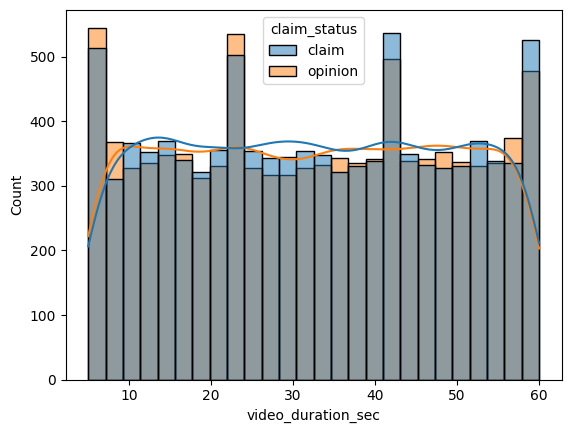

In [4]:
# en general las vistas tienen una distribucion similar en ambas clases
sns.histplot(data, x='video_duration_sec', hue='claim_status', kde=True)

In [5]:
# por lo cual las eliminamos del analisis
data = data.drop('video_duration_sec', axis=1)

In [6]:
# descripcion de datos numericos (analitics)
data.describe()

,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


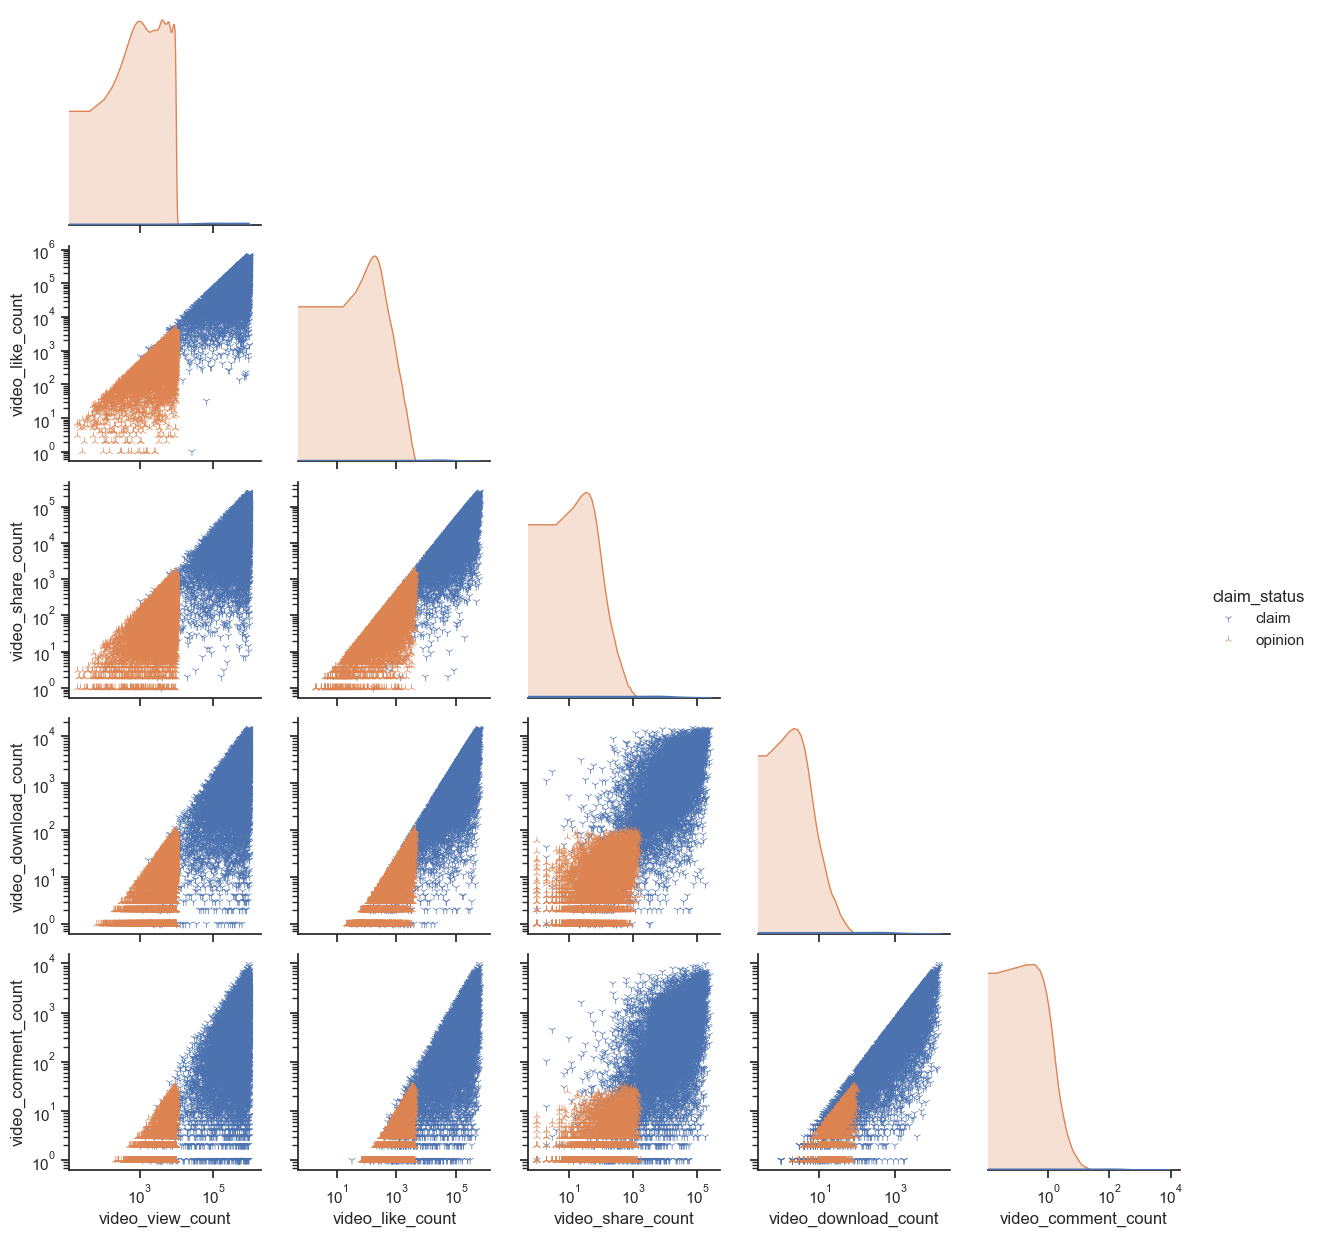

In [7]:
# inspeccion de los atributos numericos de interes (analitics)
sns.set_theme(style='ticks')
g = sns.pairplot(data, hue='claim_status', corner=True, markers=['1', '2'])

g.set(xscale="log")
g.set(yscale="log")

En general los vidoes de opninion tienen menos interacciones (vistas, likes, compartidos, descargas y comentarios) que los videos de critica, los cuales suelen ser mas polemicos y por lo cual tienen mas interacciones

## LEctura de datos

In [8]:
# convertir dataframe (pandas) a dataset (trensorflow)
def df_to_dataset(dataframe, y_label, batch=1):
  dataframe = dataframe.copy()
  labels = dataframe.pop(y_label).values
  _, labels = np.unique(labels,  return_inverse=True)
  
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels)) # dictionario y labels
  return ds.batch(batch)

In [9]:
# split de datos
train, test = train_test_split(data, test_size=0.2, random_state=1)
train, val = train_test_split(train, test_size=0.4, random_state=1)

# convertir a Dataset
BATCH_SIZE = 16
train = df_to_dataset(train, y_label='claim_status', batch=BATCH_SIZE)
test = df_to_dataset(test, y_label='claim_status', batch=BATCH_SIZE)
val = df_to_dataset(val, y_label='claim_status', batch=BATCH_SIZE)

In [10]:
# ejemplo de un elemento
[(features, label)] = train.take(1)

print('Example values')
for ki in features.keys():
    print(f'- {ki}: {features[ki][0]}')

print(f'Label: {label[0]}')

Example values
- video_transcription_text: b'my family is willing to say that take out restaurants have been found in the remains of pompeii'
- verified_status: b'verified'
- author_ban_status: b'banned'
- video_view_count: 4338
- video_like_count: 1419
- video_share_count: 252
- video_download_count: 24
- video_comment_count: 3
Label: 1


## Capas de preprocesamiento

In [2]:
# descripcion de datos numericos (analitics)
data.describe()

NameError: name 'data' is not defined

In [11]:
# input pipeline
def preprocessing_layer(name, dataset, type, max_tokens=10000, output_length=20):
    # accede a la feature deseada
    feature_ds = dataset.map(lambda x, y: x[name])
    
    if type=='numeric':
        auxIn = tf.keras.Input(shape=(1,), name=name, dtype='int64')
        layer = tf.keras.layers.Normalization(axis=None)
        layer.adapt(feature_ds)
    elif type=='categorical':
        auxIn = tf.keras.Input(shape=(1,), name=name, dtype='string')
        layer = tf.keras.layers.StringLookup(num_oov_indices=0, output_mode='one_hot')
        layer.adapt(feature_ds)
    elif type=='text':
        auxIn = tf.keras.Input(shape=(1,), name=name, dtype='string')
        layer = tf.keras.layers.TextVectorization(max_tokens=max_tokens, output_sequence_length=output_length)
        layer.adapt(feature_ds)
    
    encoded = layer(auxIn)

    return auxIn, encoded

In [12]:
# creacion de inputs pertenecientes a interesacciones y texto, por separado
inputs = []
encoded_inputs = []

# interacciones (variables continuas)
numerical = ['video_view_count', 'video_like_count', 'video_share_count', 'video_download_count',
             'video_comment_count']
for ni in numerical:
    auxIn, auxEn = preprocessing_layer(name=ni, dataset=train, type='numeric')
    inputs.append(auxIn)
    encoded_inputs.append(auxEn)

# datos del autor (categoricos)
categorical = ['verified_status', 'author_ban_status']
for ci in categorical:
    auxIn, auxEn = preprocessing_layer(name=ci, dataset=train, type='categorical')
    inputs.append(auxIn)
    encoded_inputs.append(auxEn)

# texto de la transcripcion
textIn, textEn = preprocessing_layer(name='video_transcription_text', dataset=train, type='text')
textEn = tf.cast(textEn, tf.float32) # cast a float 32
inputs.append(textIn)
encoded_inputs.append(textEn)

## Definicion del modelo

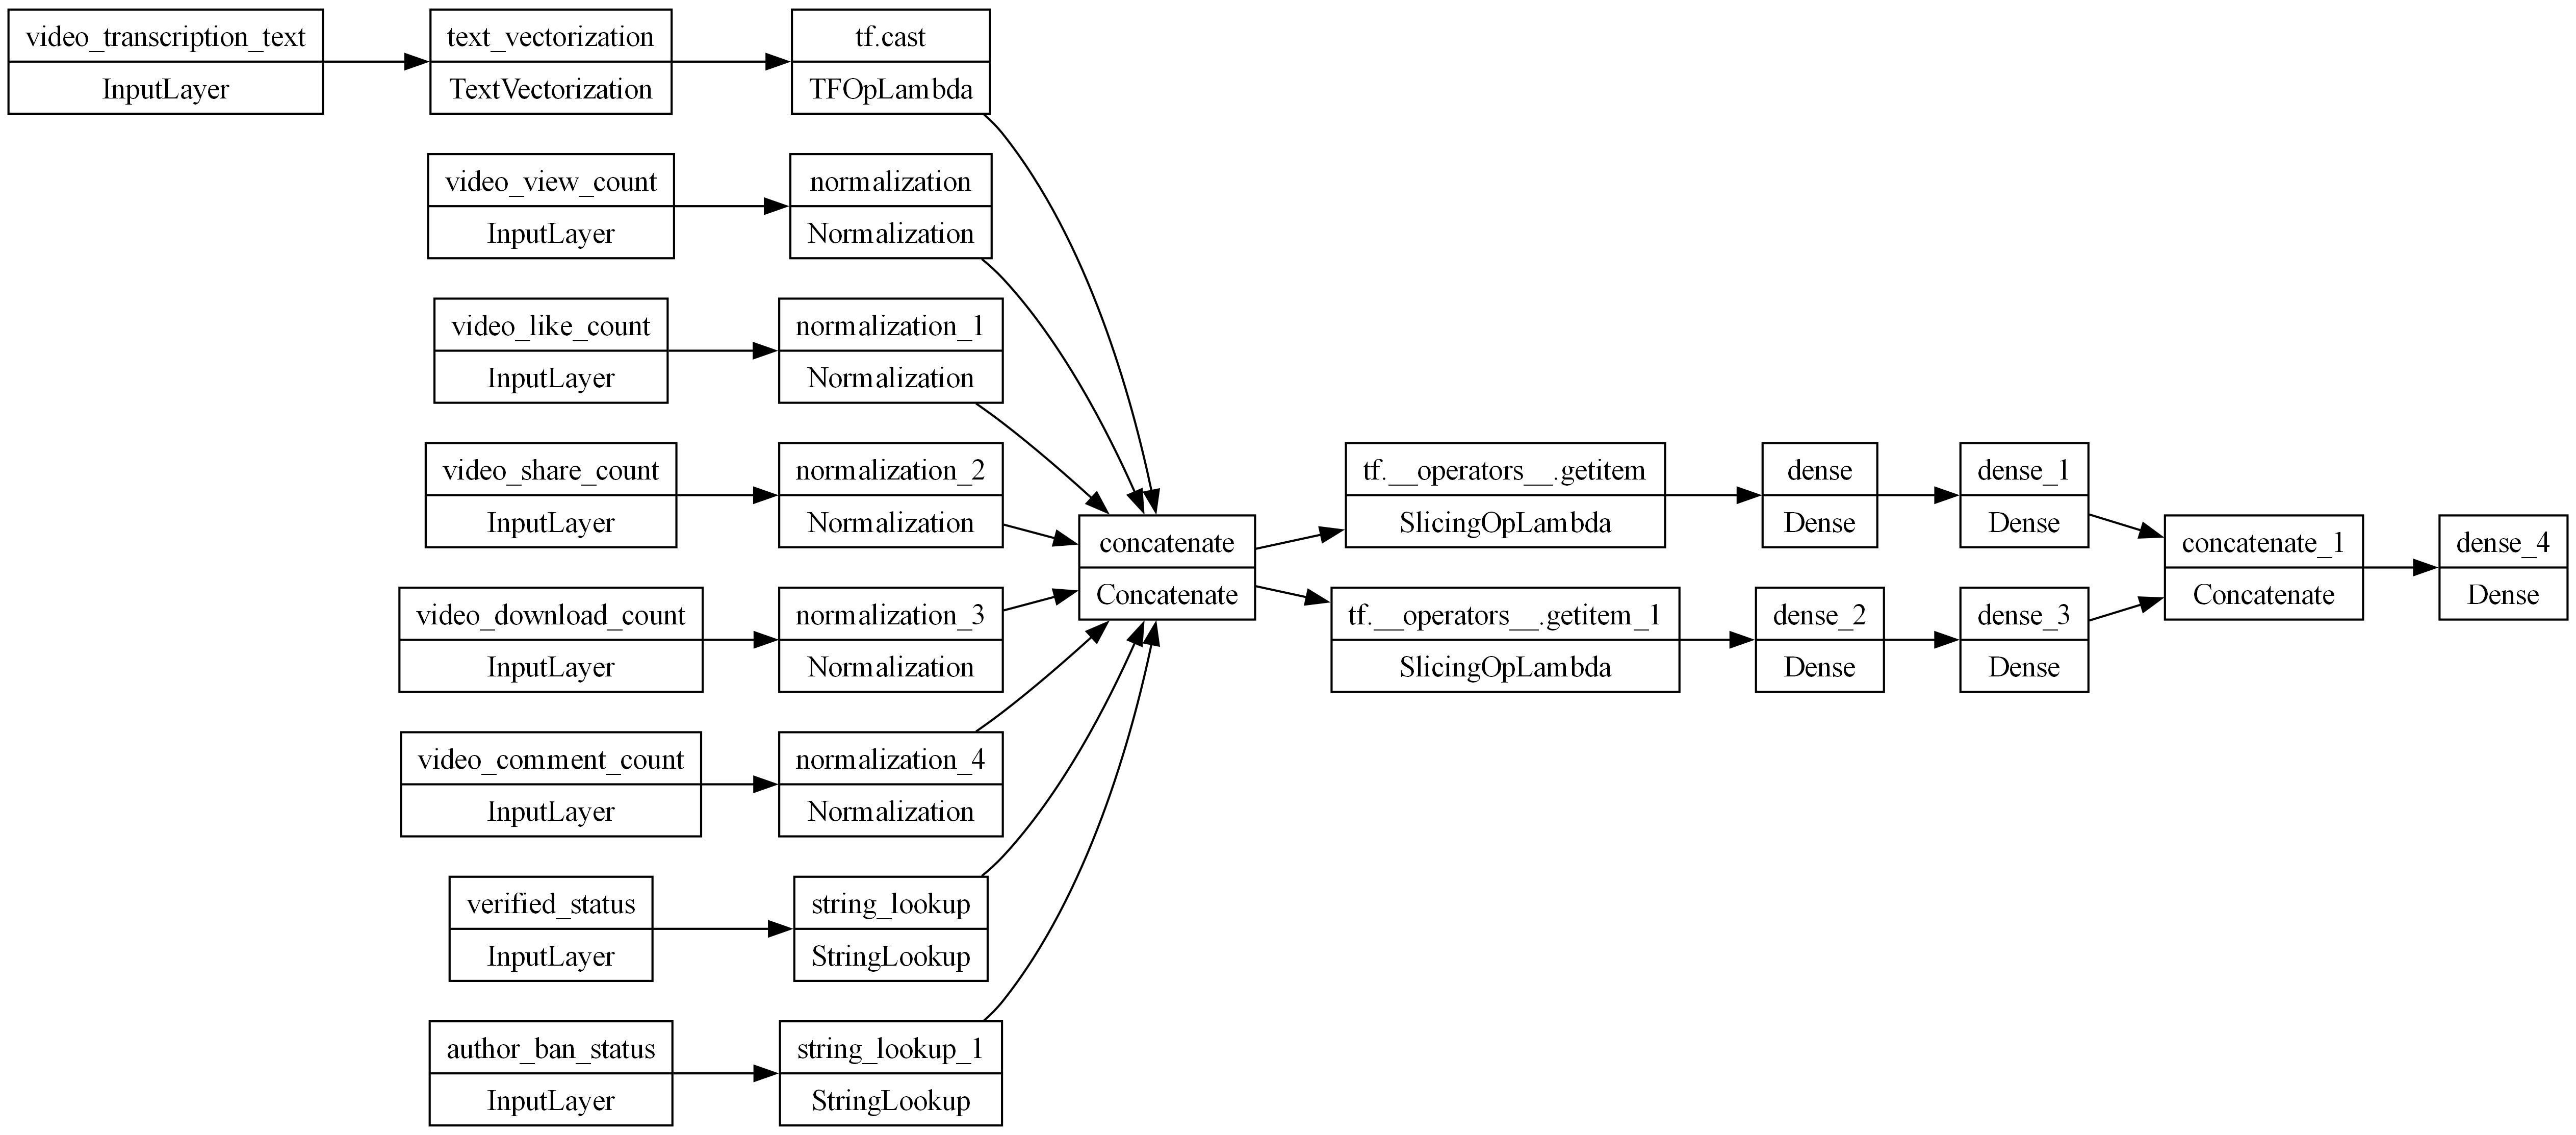

In [13]:
concat_encoded = tf.keras.layers.Concatenate(axis=-1)(encoded_inputs)

# modelo numerical
nums = concat_encoded[:,:-20]
nd1 = tf.keras.layers.Dense(32, 'relu')(nums)
nd2 = tf.keras.layers.Dense(16, 'relu')(nd1)

# modelo texto
text = concat_encoded[:,-20:]
td1 = tf.keras.layers.Dense(32, 'relu')(text)
td2 = tf.keras.layers.Dense(16, 'relu')(td1)

# concat
full_concat = tf.keras.layers.Concatenate(axis=-1)([nd2, td2])

# classificacion
out = tf.keras.layers.Dense(units=1, activation='sigmoid')(full_concat)

# model definition
model = tf.keras.Model(inputs, out)

# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=False, rankdir="LR", dpi=300)

In [14]:
class MaxAccEpoch(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
        super().__init__()
        self.epochs = epochs # number of epochs
        self.val_loss = [] # loss functions data

        self.max_epoch = 0
        self.max_val_acc = 0.0
        self.max_weights = None

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_acc') > self.max_val_acc:
            self.max_epoch = epoch
            self.max_val_acc = logs.get('val_acc')
            self.max_weights = self.model.get_weights()
        self.val_loss.append(logs.get('val_loss'))

        return super().on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        return super().on_train_end(logs)

In [15]:
EPOCHS = 10
cb = MaxAccEpoch(EPOCHS)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer='adam', metrics=['acc'])
metrics = model.fit(x=train, validation_data=val, epochs=EPOCHS, callbacks=cb)

Epoch 1/10
573/573 [==============================] - 9s 14ms/step - loss: 6.5770 - acc: 0.7907 - val_loss: 1.5025 - val_acc: 0.9155
Epoch 2/10
573/573 [==============================] - 8s 14ms/step - loss: 0.7114 - acc: 0.9405 - val_loss: 0.5424 - val_acc: 0.9327
Epoch 3/10
573/573 [==============================] - 8s 14ms/step - loss: 0.3852 - acc: 0.9567 - val_loss: 0.2790 - val_acc: 0.9550
Epoch 4/10
573/573 [==============================] - 7s 13ms/step - loss: 0.2733 - acc: 0.9657 - val_loss: 0.2156 - val_acc: 0.9704
Epoch 5/10
573/573 [==============================] - 7s 13ms/step - loss: 0.2118 - acc: 0.9713 - val_loss: 0.1763 - val_acc: 0.9782
Epoch 6/10
573/573 [==============================] - 7s 12ms/step - loss: 0.2219 - acc: 0.9716 - val_loss: 0.1753 - val_acc: 0.9725
Epoch 7/10
573/573 [==============================] - 7s 13ms/step - loss: 0.1702 - acc: 0.9766 - val_loss: 0.1437 - val_acc: 0.9840
Epoch 8/10
573/573 [==============================] - 8s 13ms/step - 

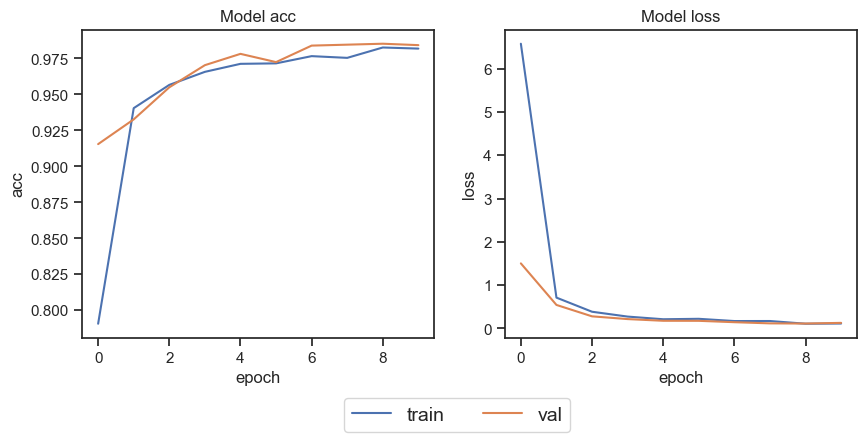

In [16]:
# plot de accuracy y loss
fig, axs = plt.subplots(1,2)
fig.set_size_inches((10,4))

labs = ['acc', 'loss']

for i, li in enumerate(labs):
    axs[i].plot(metrics.history[li], label='train')
    axs[i].plot(metrics.history[f'val_{li}'], label='val')

    axs[i].set_title(f'Model {li}')
    axs[i].set_ylabel(li)
    axs[i].set_xlabel('epoch')

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.5,-0.15), loc='outside lower center', ncol=2, labelspacing=0., fontsize=14)

plt.show()

In [18]:
# se toma el modelo con el mejor accuracy
print(f'Optimal EPOCH: {cb.max_epoch}')
model.set_weights(cb.max_weights)

test_acc = model.evaluate(test)
print(f'Loss on Test set: {test_acc[0]}')
print(f'Accuracy on Test set: {test_acc[1]}')

Optimal EPOCH: 8
239/239 [==============================] - 2s 8ms/step - loss: 0.1467 - acc: 0.9767
Loss on Test set: 0.14668568968772888
Accuracy on Test set: 0.9766832590103149


239/239 [==============================] - 2s 6ms/step
F1-Score on test set: 0.9762729938683018


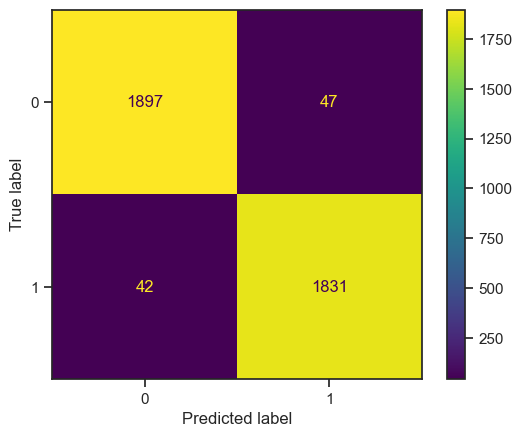

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

y_test = []
for _, label in test:
    y_test += list(np.array(label))


preds = model.predict(test)
preds = np.round(preds)
preds = np.reshape(preds, (preds.shape[0],))

labels = ['claim', 'opinion']
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# f1 score
f1 = f1_score(y_test, preds)
print(f'F1-Score on test set: {f1}')

## se guarda el modelo obtenido

In [33]:
model.save('model_test')

INFO:tensorflow:Assets written to: model_test\assets


In [34]:
reloaded_model = tf.keras.models.load_model('model_test')

In [35]:
# prueba
x_test = {'video_view_count': 20000, 'video_like_count': 200, 'video_share_count':200, 'video_download_count':20,
             'video_comment_count':50, 'verified_status':'not verified', 'author_ban_status':'active',
             'video_transcription_text': "my colleagues' point of view is that 90% of goods are shipped by ocean freight"}
x_test = {name: tf.convert_to_tensor([value]) for name, value in x_test.items()}

#dd = np.array([[20000.0, 200.0, 200.0, 20.0, 50.0, 0.0,0.0,1.0, 0.0,1.0]])

pred  = reloaded_model.predict(x_test)
pred

1/1 [==============================] - 0s 188ms/step


array([[0.00260302]], dtype=float32)